In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os
import wandb
import cv2
import dlib
import numpy as np
import time
from torch.cuda.amp import GradScaler, autocast

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define paths
shape_predictor_path = r""
neutral_folder = r''
happy_folder = r''
aligned_neutral = r''
aligned_happy = r''

# Create preprocessed directories if they don't exist
os.makedirs(aligned_neutral, exist_ok=True)
os.makedirs(aligned_happy, exist_ok=True)

# Load dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)

def align_and_save_faces(source_folder, target_folder):
    """Preprocess and save aligned faces to target folder"""
    if len(os.listdir(target_folder)) > 0:
        return  # Skip if already processed
    
    for img_name in os.listdir(source_folder):
        img_path = os.path.join(source_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        aligned = align_face(image)
        if aligned:
            aligned.save(os.path.join(target_folder, img_name))

def align_face(image):
    """Align face using facial landmarks"""
    try:
        # Convert PIL image to OpenCV format
        image_np = np.array(image)
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

        # Detect faces
        faces = detector(gray, 1)
        if not faces:
            return None  # No face detected

        # Get facial landmarks
        landmarks = predictor(gray, faces[0])
        landmarks = np.array([[p.x, p.y] for p in landmarks.parts()])

        # Define the desired eye positions for alignment
        desired_left_eye = (0.35, 0.35)  # Normalized coordinates
        desired_face_width = 256
        desired_face_height = 256

        # Get the eye centers
        left_eye_center = landmarks[36:42].mean(axis=0)  # Left eye landmarks (36-41)
        right_eye_center = landmarks[42:48].mean(axis=0)  # Right eye landmarks (42-47)

        # Calculate the angle between the eyes
        dY = right_eye_center[1] - left_eye_center[1]
        dX = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dY, dX))

        # Calculate the scale
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desired_dist = (1.0 - 2 * desired_left_eye[0]) * desired_face_width
        scale = desired_dist / dist

        # Get the rotation matrix
        eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                       (left_eye_center[1] + right_eye_center[1]) // 2)
        M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

        # Update the translation component of the matrix
        tX = desired_face_width * 0.5
        tY = desired_face_height * desired_left_eye[1]
        M[0, 2] += (tX - eyes_center[0])
        M[1, 2] += (tY - eyes_center[1])

        # Apply the affine transformation
        aligned_face = cv2.warpAffine(image_np, M, (desired_face_width, desired_face_height), flags=cv2.INTER_CUBIC)
        return Image.fromarray(aligned_face)
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Preprocess datasets once before training
#print("Preprocessing datasets...")
#align_and_save_faces(neutral_folder, aligned_neutral)
#align_and_save_faces(happy_folder, aligned_happy)

class PreprocessedDataset(Dataset):
    """Dataset that loads preprocessed images"""
    def __init__(self, folder, transform=None):
        self.image_paths = [os.path.join(folder, f) for f in os.listdir(folder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(image) if self.transform else image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Create datasets and dataloaders
print("Creating dataloaders...")
neutral_dataset = PreprocessedDataset(aligned_neutral, transform)
happy_dataset = PreprocessedDataset(aligned_happy, transform)

neutral_dataloader = DataLoader(
    neutral_dataset,
    batch_size=32,
    shuffle=True,
    pin_memory=True  # Keep pin_memory for faster GPU transfer
)

happy_dataloader = DataLoader(
    happy_dataset,
    batch_size=32,
    shuffle=True,
    pin_memory=True  # Keep pin_memory for faster GPU transfer
)

# Define the Generator (U-Net based architecture)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Downsampling layers
        self.down1 = self.conv_block(3, 64, normalize=False)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        self.down5 = self.conv_block(512, 512)

        # Upsampling layers
        self.up1 = self.deconv_block(512, 512)
        self.up2 = self.deconv_block(1024, 256)
        self.up3 = self.deconv_block(512, 128)
        self.up4 = self.deconv_block(256, 64)
        self.up5 = self.deconv_block(128, 3, normalize=False, activation=nn.Tanh())

        # Initialize weights
        self.apply(self._init_weights)

    def conv_block(self, in_channels, out_channels, normalize=True, activation=nn.LeakyReLU(0.2)):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(activation)
        return nn.Sequential(*layers)

    def deconv_block(self, in_channels, out_channels, normalize=True, activation=nn.ReLU()):
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(activation)
        return nn.Sequential(*layers)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            init.normal_(m.weight, 0.0, 0.02)  # Initialize weights with mean=0.0, std=0.02
            if m.bias is not None:
                init.constant_(m.bias, 0.0)  # Initialize biases to 0.0

    def forward(self, x):
        # Downsampling
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        # Upsampling with skip connections
        u1 = self.up1(d5)
        u2 = self.up2(torch.cat([u1, d4], dim=1))
        u3 = self.up3(torch.cat([u2, d3], dim=1))
        u4 = self.up4(torch.cat([u3, d2], dim=1))
        u5 = self.up5(torch.cat([u4, d1], dim=1))

        return u5

# Define the Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            init.normal_(m.weight, 0.0, 0.02)  # Initialize weights with mean=0.0, std=0.02
            if m.bias is not None:
                init.constant_(m.bias, 0.0)  # Initialize biases to 0.0

    def forward(self, x):
        return self.model(x)

# Initialize models
G_NeutralToHappy = Generator().to(device)
G_HappyToNeutral = Generator().to(device)
D_Neutral = Discriminator().to(device)
D_Happy = Discriminator().to(device)



Creating dataloaders...


In [ ]:
# Define optimizers
G_optimizer = optim.Adam(list(G_NeutralToHappy.parameters()) + list(G_HappyToNeutral.parameters()), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(list(D_Neutral.parameters()) + list(D_Happy.parameters()), lr=0.0002, betas=(0.5, 0.999))

# Define loss functions
criterion_gan = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Initialize wandb
wandb.init(project="cyclegan-neutral-happy", config={
    "learning_rate": 0.0002,
    "batch_size": 16,
    "epochs": 50,
    "beta1": 0.5,
    "beta2": 0.999,
    "loss": "MSE + L1"
})

# Log models and gradients
wandb.watch(G_NeutralToHappy, log="all")
wandb.watch(G_HappyToNeutral, log="all")
wandb.watch(D_Neutral, log="all")
wandb.watch(D_Happy, log="all")

# Initialize GradScaler for mixed precision training
scaler = GradScaler()


# Training loop
num_epochs = 50
lambda_cycle = 10.0
lambda_identity = 5.0

for epoch in range(num_epochs):
    epoch_start = time.time()
    print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
    
    for i, (neutral_images, happy_images) in enumerate(zip(neutral_dataloader, happy_dataloader)):
        iter_start = time.time()
        
        # Move data to device
        neutral_images = neutral_images.to(device, non_blocking=True)
        happy_images = happy_images.to(device, non_blocking=True)

        # Train Generators with mixed precision
        G_NeutralToHappy.zero_grad()
        G_HappyToNeutral.zero_grad()

        with autocast():  # Enable mixed precision
            # Identity loss
            identity_happy = G_NeutralToHappy(happy_images)
            loss_identity_happy = criterion_identity(identity_happy, happy_images)
            identity_neutral = G_HappyToNeutral(neutral_images)
            loss_identity_neutral = criterion_identity(identity_neutral, neutral_images)

            # GAN loss
            fake_happy = G_NeutralToHappy(neutral_images)
            fake_happy_pred = D_Happy(fake_happy)
            loss_gan_NeutralToHappy = criterion_gan(fake_happy_pred, torch.ones_like(fake_happy_pred))

            fake_neutral = G_HappyToNeutral(happy_images)
            fake_neutral_pred = D_Neutral(fake_neutral)
            loss_gan_HappyToNeutral = criterion_gan(fake_neutral_pred, torch.ones_like(fake_neutral_pred))

            # Cycle-consistency loss
            reconstructed_neutral = G_HappyToNeutral(fake_happy)
            loss_cycle_Neutral = criterion_cycle(reconstructed_neutral, neutral_images)
            reconstructed_happy = G_NeutralToHappy(fake_neutral)
            loss_cycle_Happy = criterion_cycle(reconstructed_happy, happy_images)

            # Total generator loss
            G_loss = (
                loss_gan_NeutralToHappy + loss_gan_HappyToNeutral +
                lambda_cycle * (loss_cycle_Neutral + loss_cycle_Happy) +
                lambda_identity * (loss_identity_happy + loss_identity_neutral)
            )

        # Backpropagation with scaling
        scaler.scale(G_loss).backward()
        scaler.step(G_optimizer)
        scaler.update()

        # Train Discriminators with mixed precision
        D_Neutral.zero_grad()
        D_Happy.zero_grad()

        with autocast():
            # Real images
            real_neutral_pred = D_Neutral(neutral_images)
            loss_real_neutral = criterion_gan(real_neutral_pred, torch.ones_like(real_neutral_pred))
            real_happy_pred = D_Happy(happy_images)
            loss_real_happy = criterion_gan(real_happy_pred, torch.ones_like(real_happy_pred))

            # Fake images
            fake_neutral_pred = D_Neutral(fake_neutral.detach())
            loss_fake_neutral = criterion_gan(fake_neutral_pred, torch.zeros_like(fake_neutral_pred))
            fake_happy_pred = D_Happy(fake_happy.detach())
            loss_fake_happy = criterion_gan(fake_happy_pred, torch.zeros_like(fake_happy_pred))

            # Total discriminator loss
            D_loss = (loss_real_neutral + loss_fake_neutral + loss_real_happy + loss_fake_happy) / 2

        # Backpropagation with scaling
        scaler.scale(D_loss).backward()
        scaler.step(D_optimizer)
        scaler.update()

        # Logging and progress reporting
        if i % 20 == 0:
            iter_time = time.time() - iter_start
            print(f"Epoch {epoch+1} | Batch {i}/{len(neutral_dataloader)} | "
                  f"Time: {iter_time:.2f}s | G_loss: {G_loss.item():.4f} | D_loss: {D_loss.item():.4f}")

        # Log losses to wandb
        wandb.log({
            "G_loss": G_loss.item(),
            "D_loss": D_loss.item(),
            "epoch": epoch,
            "step": i
        })

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1} completed in {epoch_time//60:.0f}m {epoch_time%60:.0f}s")
    
    # Save checkpoints and samples
    with torch.no_grad():
        fake_happy = G_NeutralToHappy(neutral_images)
        fake_neutral = G_HappyToNeutral(happy_images)
        save_image(fake_happy, f'fake_happy_epoch_{epoch+1}.png', normalize=True)
        save_image(fake_neutral, f'fake_neutral_epoch_{epoch+1}.png', normalize=True)
        # Log generated images to wandb
        wandb.log({
            "Fake Happy": [wandb.Image(fake_happy[0], caption=f"Epoch {epoch+1}")],
            "Fake Neutral": [wandb.Image(fake_neutral[0], caption=f"Epoch {epoch+1}")]
        })

# Save the models
torch.save(G_NeutralToHappy.state_dict(), 'G_NeutralToHappy.pth')
torch.save(G_HappyToNeutral.state_dict(), 'G_HappyToNeutral.pth')
torch.save(D_Neutral.state_dict(), 'D_Neutral.pth')
torch.save(D_Happy.state_dict(), 'D_Happy.pth')

# Finish wandb run
wandb.finish()

Creating dataloaders...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: utkarshrawat04 (utkarshrawat04-nmims) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


C:\Users\Asus\AppData\Local\Temp\ipykernel_20704\3497550897.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Starting Epoch 1/50


C:\Users\Asus\AppData\Local\Temp\ipykernel_20704\3497550897.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
C:\Users\Asus\AppData\Local\Temp\ipykernel_20704\3497550897.py:329: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Batch 0/3350 | Time: 1.43s | G_loss: 17.9313 | D_loss: 3.4404
Epoch 1 | Batch 20/3350 | Time: 0.61s | G_loss: 12.4709 | D_loss: 1.4226
Epoch 1 | Batch 40/3350 | Time: 0.61s | G_loss: 7.6199 | D_loss: 0.8705
Epoch 1 | Batch 60/3350 | Time: 0.64s | G_loss: 6.9899 | D_loss: 0.6641
Epoch 1 | Batch 80/3350 | Time: 0.60s | G_loss: 5.5530 | D_loss: 0.6229
Epoch 1 | Batch 100/3350 | Time: 0.60s | G_loss: 4.7144 | D_loss: 0.5876
Epoch 1 | Batch 120/3350 | Time: 0.60s | G_loss: 4.1896 | D_loss: 0.5692
Epoch 1 | Batch 140/3350 | Time: 0.60s | G_loss: 3.7176 | D_loss: 0.5500
Epoch 1 | Batch 160/3350 | Time: 0.60s | G_loss: 3.2513 | D_loss: 0.5521
Epoch 1 | Batch 180/3350 | Time: 0.60s | G_loss: 3.1256 | D_loss: 0.5431
Epoch 1 | Batch 200/3350 | Time: 0.60s | G_loss: 2.9228 | D_loss: 0.5319
Epoch 1 | Batch 220/3350 | Time: 0.60s | G_loss: 2.9243 | D_loss: 0.5366
Epoch 1 | Batch 240/3350 | Time: 0.60s | G_loss: 2.7169 | D_loss: 0.5444
Epoch 1 | Batch 260/3350 | Time: 0.60s | G_loss: 2.7476

C:\Users\Asus\AppData\Local\Temp\ipykernel_20704\3497550897.py:329: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\Asus\AppData\Local\Temp\ipykernel_20704\3497550897.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision


Epoch 1 | Batch 340/3350 | Time: 0.60s | G_loss: 2.4480 | D_loss: 0.5134
Epoch 1 | Batch 360/3350 | Time: 0.60s | G_loss: 2.1895 | D_loss: 0.5249
Epoch 1 | Batch 380/3350 | Time: 0.60s | G_loss: 2.3312 | D_loss: 0.5322
Epoch 1 | Batch 400/3350 | Time: 0.60s | G_loss: 2.2897 | D_loss: 0.5996
Epoch 1 | Batch 420/3350 | Time: 0.60s | G_loss: 2.2009 | D_loss: 0.5339
Epoch 1 | Batch 440/3350 | Time: 0.60s | G_loss: 2.1207 | D_loss: 0.5097
Epoch 1 | Batch 460/3350 | Time: 0.60s | G_loss: 2.3607 | D_loss: 0.6668
Epoch 1 | Batch 480/3350 | Time: 0.60s | G_loss: 2.0289 | D_loss: 0.5031
Epoch 1 | Batch 500/3350 | Time: 0.60s | G_loss: 2.0843 | D_loss: 0.5733
Epoch 1 | Batch 520/3350 | Time: 0.61s | G_loss: 2.0170 | D_loss: 0.5168
Epoch 1 | Batch 540/3350 | Time: 0.60s | G_loss: 2.1579 | D_loss: 0.5829
Epoch 1 | Batch 560/3350 | Time: 0.60s | G_loss: 1.9515 | D_loss: 0.5066
Epoch 1 | Batch 580/3350 | Time: 0.60s | G_loss: 1.9235 | D_loss: 0.5165
Epoch 1 | Batch 600/3350 | Time: 0.59s | G_loss: 2.

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os
import cv2
import dlib
import numpy as np

# Define device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r"")

# Function to align faces using facial landmarks
def align_face(image):
    # Convert PIL image to OpenCV format
    image_np = np.array(image)
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    
    # Detect faces
    faces = detector(gray)
    if len(faces) == 0:
        return image  # Return original if no face detected
    
    # Get facial landmarks
    landmarks = predictor(gray, faces[0])
    landmarks = np.array([[p.x, p.y] for p in landmarks.parts()])
    
    # Alignment calculations (same as in training)
    desired_left_eye = (0.35, 0.35)
    desired_face_width = 256
    desired_face_height = 256
    
    left_eye_center = landmarks[36:42].mean(axis=0)
    right_eye_center = landmarks[42:48].mean(axis=0)
    
    # Calculate angle and scale
    dY = right_eye_center[1] - left_eye_center[1]
    dX = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dY, dX))
    
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desired_dist = (1.0 - 2 * desired_left_eye[0]) * desired_face_width
    scale = desired_dist / dist
    
    # Get rotation matrix
    eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                   (left_eye_center[1] + right_eye_center[1]) // 2)
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)
    
    # Adjust translation
    tX = desired_face_width * 0.5
    tY = desired_face_height * desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])
    
    # Apply affine transformation
    aligned_face = cv2.warpAffine(image_np, M, (desired_face_width, desired_face_height), 
                                 flags=cv2.INTER_CUBIC)
    
    return Image.fromarray(aligned_face)

# Define transformations (must match training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the trained generators
G_NeutralToHappy = Generator().to(device)
G_HappyToNeutral = Generator().to(device)

G_NeutralToHappy.load_state_dict(torch.load(r'', map_location=device))
G_HappyToNeutral.load_state_dict(torch.load(r'', map_location=device))

# Set models to evaluation mode
G_NeutralToHappy.eval()
G_HappyToNeutral.eval()

def transform_image(image_path, generator, save_path):
    # Load and align image
    original_image = Image.open(image_path).convert('RGB')
    aligned_image = align_face(original_image)  # Apply alignment
    
    # Preprocess
    image_tensor = transform(aligned_image).unsqueeze(0).to(device)
    
    # Generate output
    with torch.no_grad():
        output_tensor = generator(image_tensor)
    
    # Postprocess
    output_tensor = output_tensor.squeeze().cpu()
    output_tensor = (output_tensor + 1) / 2  # Denormalize
    output_image = transforms.ToPILImage()(output_tensor)
    
    # Save
    output_image.save(save_path)
    print(f"Transformed image saved to {save_path}")

# Example usage
neutral_image_path = r''
happy_image_path = r''

# Neutral -> Happy
transform_image(neutral_image_path, G_NeutralToHappy, 'result_happy.jpg')

# Happy -> Neutral
transform_image(happy_image_path, G_HappyToNeutral, 'result_neutral.jpg')

Transformed image saved to result_happy.jpg
Transformed image saved to result_neutral.jpg


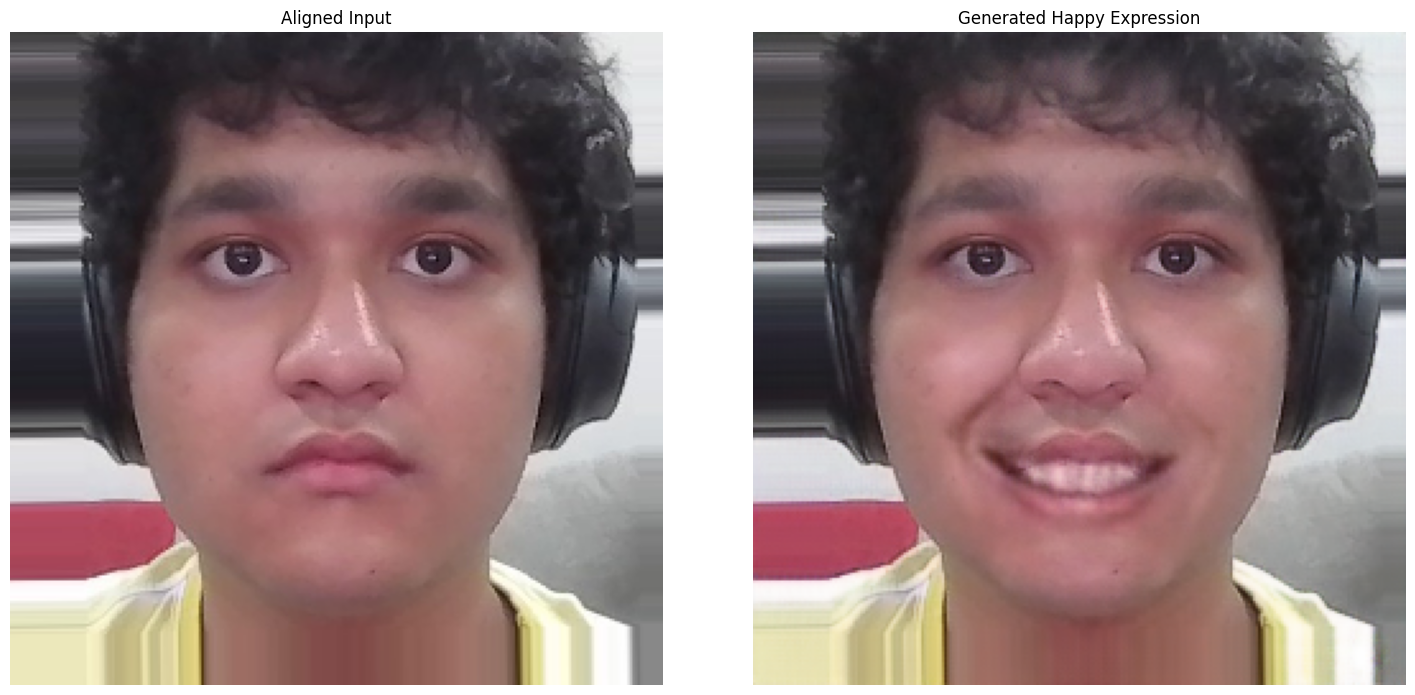

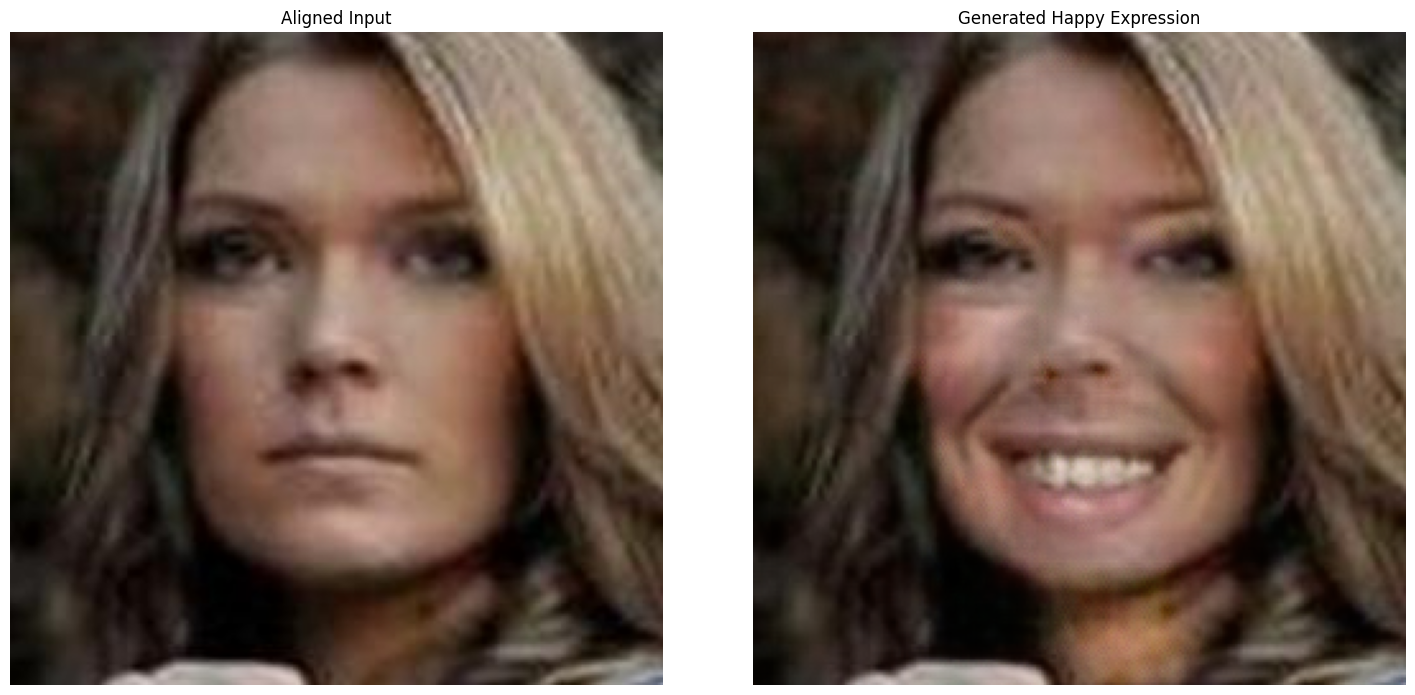

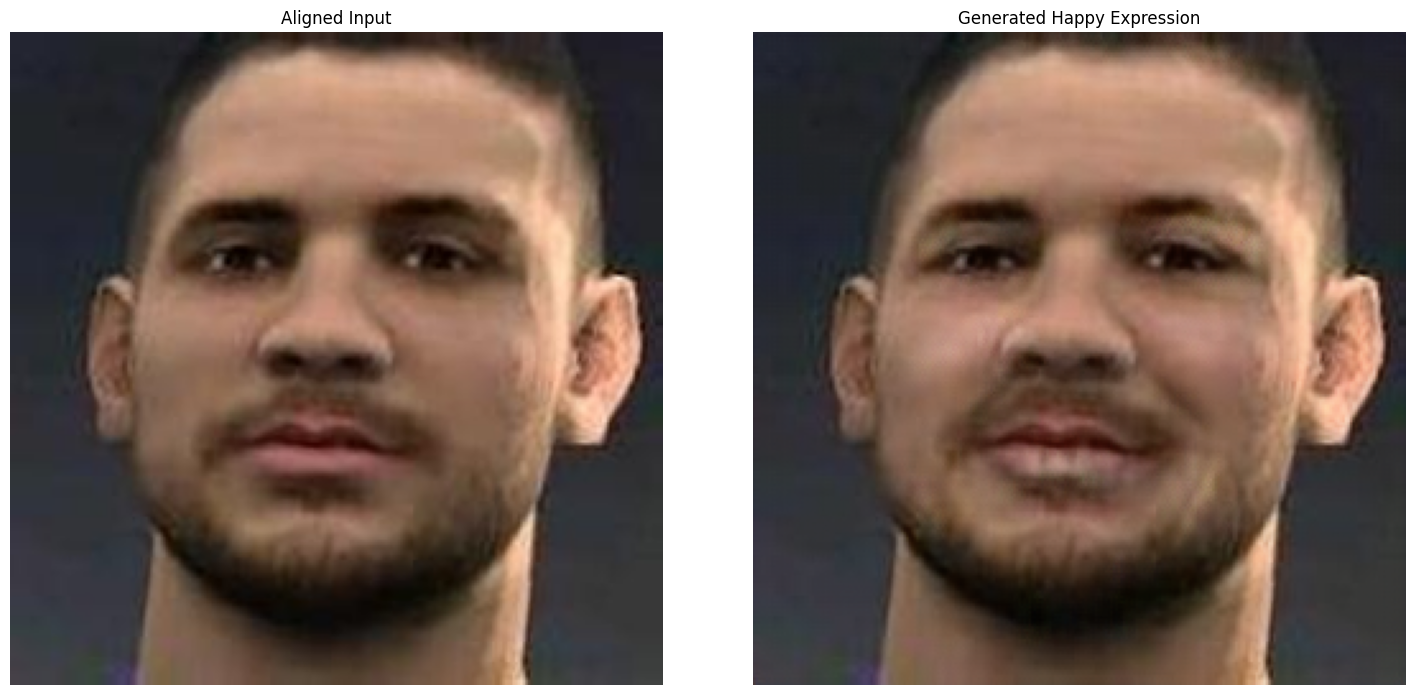

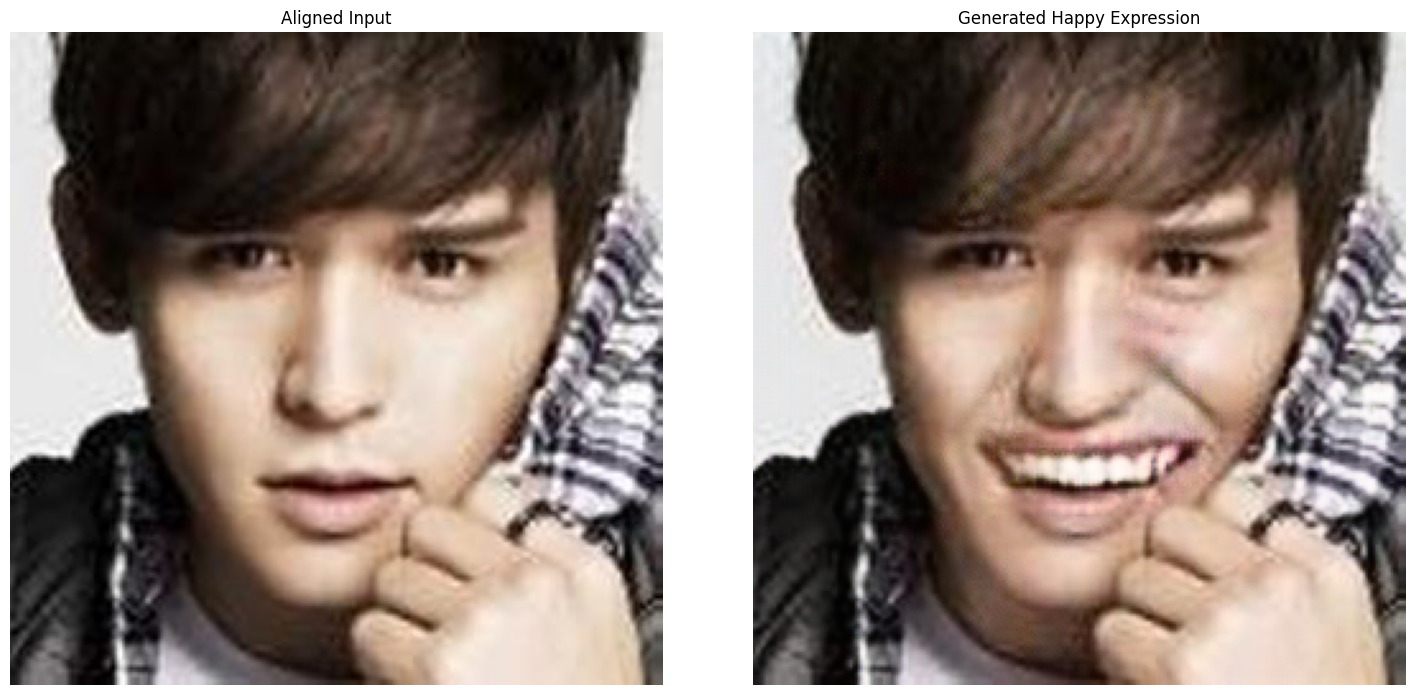

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os
import wandb
import cv2
import dlib
import numpy as np
import time
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt

# Define device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r"")

def align_face(image):
    """Robust face alignment implementation with error handling"""
    try:
        image_np = np.array(image)
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        
        # Detect faces with upsampling
        faces = detector(gray, 1)
        if not faces:
            print("No faces detected")
            return None
            
        # Use first detected face
        face = faces[0]
        
        # Get facial landmarks
        landmarks = predictor(gray, face)
        if not landmarks:
            print("No landmarks detected")
            return None
            
        # Convert landmarks to numpy array
        landmarks = np.array([[p.x, p.y] for p in landmarks.parts()], dtype=np.int32)
        if landmarks.size == 0:
            print("Empty landmarks array")
            return None
            
        # Calculate eye positions
        try:
            left_eye_points = landmarks[36:42]
            right_eye_points = landmarks[42:48]
            
            if len(left_eye_points) < 6 or len(right_eye_points) < 6:
                print("Incomplete eye landmarks")
                return None
                
            left_eye_center = left_eye_points.mean(axis=0).astype(np.int32)
            right_eye_center = right_eye_points.mean(axis=0).astype(np.int32)
            
        except IndexError as e:
            print(f"Landmark error: {str(e)}")
            return None
            
        # Calculate angle and scale
        dY = right_eye_center[1] - left_eye_center[1]
        dX = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dY, dX))
        
        desired_left_eye = (0.35, 0.35)
        desired_face_width = 256
        desired_face_height = 256
        
        dist = np.sqrt((dX**2) + (dY**2))
        desired_dist = (1.0 - 2 * desired_left_eye[0]) * desired_face_width
        scale = desired_dist / max(dist, 1e-6)
        
        eyes_center = (
            int((left_eye_center[0] + right_eye_center[0]) // 2),
            int((left_eye_center[1] + right_eye_center[1]) // 2)
        )
        
        M = cv2.getRotationMatrix2D(eyes_center, angle, scale)
        M[0, 2] += (desired_face_width * 0.5 - eyes_center[0])
        M[1, 2] += (desired_face_height * desired_left_eye[1] - eyes_center[1])
        
        aligned_face = cv2.warpAffine(
            image_np, M, (desired_face_width, desired_face_height),
            flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
        )
        
        return Image.fromarray(aligned_face)
        
    except Exception as e:
        print(f"Alignment error: {str(e)}")
        return None

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Downsampling layers
        self.down1 = self.conv_block(3, 64, normalize=False)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        self.down5 = self.conv_block(512, 512)

        # Upsampling layers
        self.up1 = self.deconv_block(512, 512)
        self.up2 = self.deconv_block(1024, 256)
        self.up3 = self.deconv_block(512, 128)
        self.up4 = self.deconv_block(256, 64)
        self.up5 = self.deconv_block(128, 3, normalize=False, activation=nn.Tanh())

        # Initialize weights
        self.apply(self._init_weights)

    def conv_block(self, in_channels, out_channels, normalize=True, activation=nn.LeakyReLU(0.2)):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(activation)
        return nn.Sequential(*layers)

    def deconv_block(self, in_channels, out_channels, normalize=True, activation=nn.ReLU()):
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(activation)
        return nn.Sequential(*layers)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0.0)

    def forward(self, x):
        # Downsampling
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        # Upsampling with skip connections
        u1 = self.up1(d5)
        u2 = self.up2(torch.cat([u1, d4], dim=1))
        u3 = self.up3(torch.cat([u2, d3], dim=1))
        u4 = self.up4(torch.cat([u3, d2], dim=1))
        u5 = self.up5(torch.cat([u4, d1], dim=1))

        return u5

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0.0)

    def forward(self, x):
        return self.model(x)
    
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load trained models
G_NeutralToHappy = Generator().to(device)
G_HappyToNeutral = Generator().to(device)
G_NeutralToHappy.load_state_dict(torch.load(r'', map_location=device))
G_HappyToNeutral.load_state_dict(torch.load(r'', map_location=device))
G_NeutralToHappy.eval()
G_HappyToNeutral.eval()

def display_transformation(image_path, generator, title):
    try:
        # Load and align
        original = Image.open(image_path).convert('RGB')
        aligned = align_face(original)
        
        if aligned is None:
            print("No face detected - showing original")
            aligned = original.resize((256, 256))
            
        # Preprocess
        tensor = transform(aligned).unsqueeze(0).to(device)
        
        # Generate
        with torch.no_grad():
            output = generator(tensor)
        
        # Postprocess
        output = output.squeeze().cpu().numpy()
        output = np.transpose(output, (1, 2, 0))
        output = (output * 0.5 + 0.5)  # Denormalize
        
        # Create figure
        fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        
        # Show aligned input
        ax[0].imshow(aligned)
        ax[0].set_title('Aligned Input')
        ax[0].axis('off')
        
        # Show generated output
        ax[1].imshow(output)
        ax[1].set_title(title)
        ax[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Processing failed: {str(e)}")

test_images = [
    (r"", G_NeutralToHappy, "Generated Happy Expression"),
    (r"", G_NeutralToHappy, "Generated Happy Expression"),
    (r"", G_NeutralToHappy, "Generated Happy Expression"),
    (r"", G_NeutralToHappy, "Generated Happy Expression")
    
]

for img_path, model, title in test_images:
    display_transformation(img_path, model, title)